#### Imports

In [1]:
# Import sklearn/tensorflow modules.
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import other modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from time import sleep
from sportsipy.mlb.teams import Teams
from IPython.display import clear_output
%matplotlib inline

dataset = pd.read_csv('data.csv')
display(dataset)


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,PHI,NL,1962,705,759,81,0.330,0.390,0.260,0,NaN,NaN,161,NaN,NaN
1228,PIT,NL,1962,706,626,93,0.321,0.394,0.268,0,NaN,NaN,161,NaN,NaN
1229,SFG,NL,1962,878,690,103,0.341,0.441,0.278,1,1.0,2.0,165,NaN,NaN
1230,STL,NL,1962,774,664,84,0.335,0.394,0.271,0,NaN,NaN,163,NaN,NaN


#### Add more data from `sportsipy` module

In [2]:
ERA = []
ERA_PLUS = []
FIP = []
HR = []
RBIs = []
Ks = []

for row in dataset.index:
    team = dataset.loc[row]['Team']
    year = dataset.loc[row]['Year']

    team_object = Teams(year)[team]
    
    ERA.append(team_object.earned_runs_against)
    ERA_PLUS.append(team_object.earned_runs_against_plus)
    FIP.append(team_object.fielding_independent_pitching)
    HR.append(team_object.home_runs)
    RBIs.append(team_object.runs_batted_in)
    Ks.append(team_object.strikeouts)


dataset['ERA'] = ERA
dataset['ERA+'] = ERA_PLUS
dataset['FIP'] = FIP
dataset['HR'] = HR
dataset['RBIs'] = RBIs
dataset['Ks'] = Ks
    
display(dataset)


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,...,RankPlayoffs,G,OOBP,OSLG,ERA,ERA+,FIP,HR,RBIs,Ks
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,...,NaN,162,0.317,0.415,3.93,104,3.80,165,710,1200
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,...,5.0,162,0.306,0.378,3.42,117,3.74,149,660,1232
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,...,4.0,162,0.315,0.403,3.90,109,4.20,214,677,1177
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,...,NaN,162,0.331,0.428,4.70,90,4.41,165,695,1176
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,...,NaN,162,0.335,0.424,4.51,91,4.46,137,570,1128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,PHI,NL,1962,705,759,81,0.330,0.390,0.260,0,...,NaN,161,NaN,NaN,4.28,91,4.13,142,658,863
1228,PIT,NL,1962,706,626,93,0.321,0.394,0.268,0,...,NaN,161,NaN,NaN,3.37,117,3.46,108,655,897
1229,SFG,NL,1962,878,690,103,0.341,0.441,0.278,1,...,2.0,165,NaN,NaN,3.79,101,3.81,204,807,886
1230,STL,NL,1962,774,664,84,0.335,0.394,0.271,0,...,NaN,163,NaN,NaN,3.55,121,3.81,137,707,914


In [3]:
print(dataset.columns)
print(np.unique(dataset['Year']))    # spans from 1962 - 2012

sleep(7)
clear_output()

print(dataset.isnull().sum())
dataset.drop(columns=['RankSeason', 'RankPlayoffs', 'OOBP', 'OSLG', 'RS', 'RA', 'W', 'G'], inplace=True)    # drop ones with null values.

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      988
RankPlayoffs    988
G                 0
OOBP            812
OSLG            812
ERA               0
ERA+              0
FIP               0
HR                0
RBIs              0
Ks                0
dtype: int64


In [4]:
display(dataset)

,Team,League,Year,OBP,SLG,BA,Playoffs,ERA,ERA+,FIP,HR,RBIs,Ks
0,ARI,NL,2012,0.328,0.418,0.259,0,3.93,104,3.80,165,710,1200
1,ATL,NL,2012,0.320,0.389,0.247,1,3.42,117,3.74,149,660,1232
2,BAL,AL,2012,0.311,0.417,0.247,1,3.90,109,4.20,214,677,1177
3,BOS,AL,2012,0.315,0.415,0.260,0,4.70,90,4.41,165,695,1176
4,CHC,NL,2012,0.302,0.378,0.240,0,4.51,91,4.46,137,570,1128
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,PHI,NL,1962,0.330,0.390,0.260,0,4.28,91,4.13,142,658,863
1228,PIT,NL,1962,0.321,0.394,0.268,0,3.37,117,3.46,108,655,897
1229,SFG,NL,1962,0.341,0.441,0.278,1,3.79,101,3.81,204,807,886
1230,STL,NL,1962,0.335,0.394,0.271,0,3.55,121,3.81,137,707,914


#### More data preparation

In [5]:
target = (dataset['Playoffs'])
data_moneyball = (dataset[['OBP', 'SLG', 'FIP']])    # chosing these stats because these are valued most.
data_all = (dataset[['OBP', 'SLG', 'BA', 'ERA', 'ERA+', 'FIP']])

display(target)
display(data_moneyball)
display(data_all)

# ---- VARIABLE DESCRIPTIONS ----
# OBP:          on-base percentage
# SLG:          slugging percentage
# BA:           batting average
# Playoffs:     binary (if team made playoffs or not)
# ERA:          earned run average
# ERA+:         earned run average +
# FIP:          fielding independent pitching
# HR:           home runs
# RBIs:         runs batted in
# Ks:           strikeouts

target = target.to_numpy()
data_moneyball = data_moneyball.to_numpy()
data_all = data_all.to_numpy()


0       0
1       1
2       1
3       0
4       0
       ..
1227    0
1228    0
1229    1
1230    0
1231    0
Name: Playoffs, Length: 1232, dtype: int64

,OBP,SLG,FIP
0,0.328,0.418,3.80
1,0.320,0.389,3.74
2,0.311,0.417,4.20
3,0.315,0.415,4.41
4,0.302,0.378,4.46
...,...,...,...
1227,0.330,0.390,4.13
1228,0.321,0.394,3.46
1229,0.341,0.441,3.81
1230,0.335,0.394,3.81


,OBP,SLG,BA,ERA,ERA+,FIP
0,0.328,0.418,0.259,3.93,104,3.80
1,0.320,0.389,0.247,3.42,117,3.74
2,0.311,0.417,0.247,3.90,109,4.20
3,0.315,0.415,0.260,4.70,90,4.41
4,0.302,0.378,0.240,4.51,91,4.46
...,...,...,...,...,...,...
1227,0.330,0.390,0.260,4.28,91,4.13
1228,0.321,0.394,0.268,3.37,117,3.46
1229,0.341,0.441,0.278,3.79,101,3.81
1230,0.335,0.394,0.271,3.55,121,3.81


#### Split up data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_moneyball, target, stratify=target)

print(f'X_train.shape: {X_train.shape}; y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}; y_test.shape: {y_test.shape}')

X_train.shape: (924, 3); y_train.shape: (924,)
X_test.shape: (308, 3); y_test.shape: (308,)


#### Create model to simulate moneyball theory

0.801948051948052
0.801948051948052


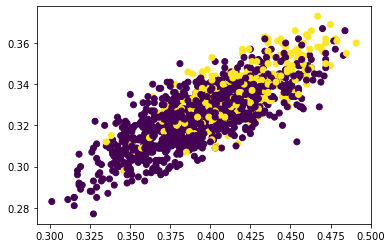

In [7]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.manifold import TSNE

model = LogisticRegression()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

plt.scatter(data_moneyball[:, 1], data_moneyball[:, 0], c=target)    # lol data ain't linear


#### Test model between two different time periods (1962 - 1993 & 1994 - 2012)

0.84


c:\Users\rohan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\rohan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


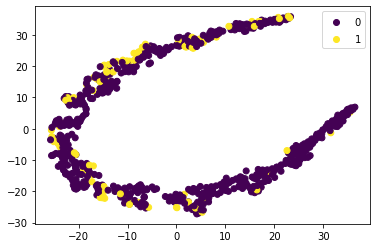

In [13]:
def time_period_test(year, symbol):
    if symbol == '<':
        dataset_time_period = dataset.loc[dataset['Year'] < year]
    elif symbol == '>':
        dataset_time_period = dataset.loc[dataset['Year'] > year]
    else:
        print(f"Invalid symbol '{symbol}'")

    data_time_period = (dataset_time_period[['SLG', 'OBP', 'FIP']]).to_numpy()
    target_time_period = (dataset_time_period['Playoffs']).to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(data_time_period, target_time_period)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))

    tsne = TSNE()    # TODO: find how to better visualize multi-variable data.

    data_trans = tsne.fit_transform(data_time_period)
    
    scatter = plt.scatter(data_trans[:, 0], data_trans[:, 1], c=target_time_period)
    plt.legend(*scatter.legend_elements())

time_period_test(1993, '<')    # TODO: figure out how to add these graphs together.
# time_period_test(1994, '>')

# 🤣🤣


In [ ]:
print(dataset['FIP'])

KeyError: 'FIP'